<a href="https://colab.research.google.com/github/Lilhxr/leaf_detect/blob/main/attention_heat_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive/cassava-deit-swin/'

In [ ]:
!pip install huggingface-hub

In [4]:
from huggingface_hub.keras_mixin import from_pretrained_keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from io import BytesIO
import numpy as np
from matplotlib import pyplot as plt

In [5]:
RESOLUTION = 224
PATCH_SIZE = 16
crop_layer = layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = layers.Rescaling(scale=1./127.5, offset=-1)

In [6]:
def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = tf.expand_dims(image, 0)
    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)
    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")
    # Crop the image.
    image = crop_layer(image)
    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)
    return image.numpy()

In [7]:
def load_image_from_local(img_path, model_type):
    # Credit: Willi Gierke
    image = Image.open(img_path)
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image

In [8]:
# Preprocess the same image but with normlization.
image_path = './data/cassava_leaf_data/train/cbb/train-cbb-0.jpg'
image, preprocessed_image = load_image_from_local(image_path, model_type="dino")

In [ ]:
# load dino model
dino = from_pretrained_keras("probing-vits/vit-dino-base16")

In [10]:
# Get the attention scores
_, attention_score_dict = dino.predict(preprocessed_image)

In [11]:
def attention_heatmap(attention_score_dict, image, model_type="dino", num_heads=12):
    num_tokens = 2 if "distilled" in model_type else 1
    
    # Sort the transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(attentions, size=(
        h_featmap * PATCH_SIZE,
        w_featmap * PATCH_SIZE)
    )
    return attentions

In [12]:
def plot(attentions, image):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
    img_count = 0

    for i in range(3):
        for j in range(4):
            if img_count < len(attentions):
                axes[i, j].imshow(image[0])
                axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
                axes[i, j].title.set_text(f"Attention head: {img_count}")
                axes[i, j].axis("off")
                img_count += 1
    
    plt.tight_layout()
    plt.savefig("./heat_map.png")

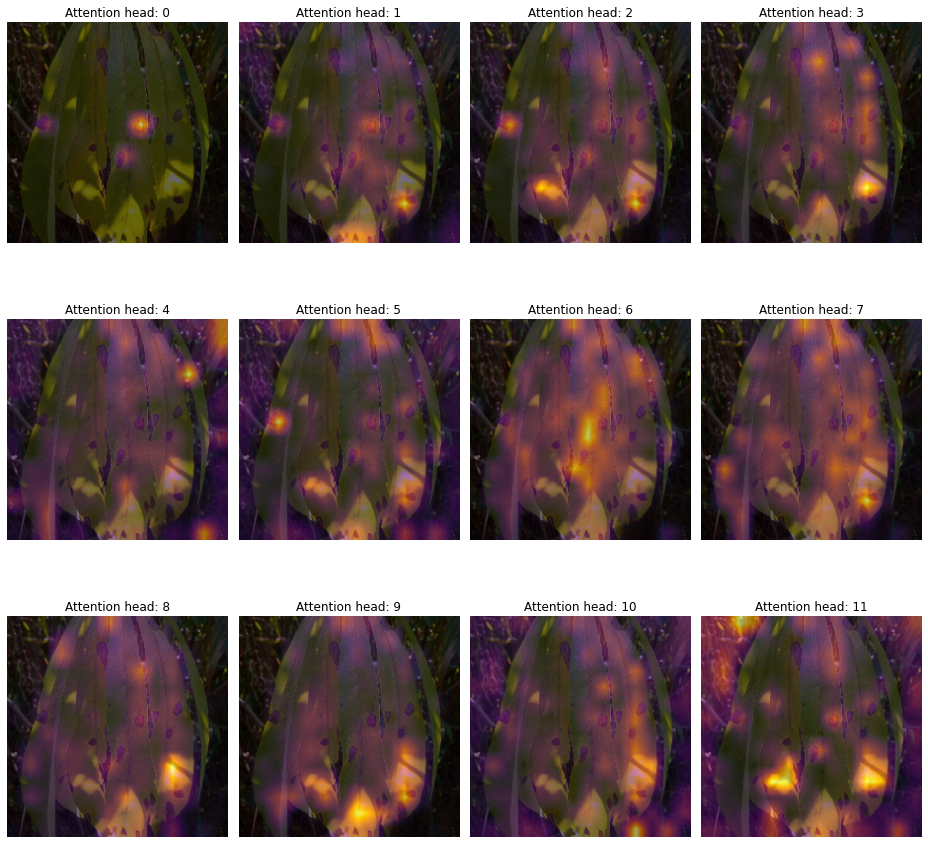

In [13]:
# De-normalize the image for visual clarity. 
in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  
in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.
preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

attentions = attention_heatmap(
	attention_score_dict=attention_score_dict,
	image=preprocessed_img_orig
)
plot(attentions=attentions, image=preprocessed_img_orig)